# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:11<00:00, 15439022.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1
BATCH_SIZE = 128
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

CUDA Available? True


In [6]:
print(len(train_loader))
print(len(test_loader))

391
79


In [7]:
for batch in train_loader:
       print(batch[0].shape)
       break

torch.Size([128, 3, 32, 32])


In [8]:
for batch in train_loader:
       print(batch[1].shape)
       break

torch.Size([128])


In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

 bird   cat truck   car   cat horse truck   cat  deer horse   cat plane truck truck   cat   cat   car horse  bird  ship   cat  bird truck horse  frog  ship  ship   dog   dog   dog   car  frog  frog horse   cat truck horse  deer  ship  deer  frog plane  deer plane  frog  bird  ship  ship plane  frog  deer   dog  ship  ship   dog  deer   cat horse  bird  bird  deer   car  deer horse truck plane horse plane   dog plane plane horse   cat   dog truck plane  deer truck horse horse truck truck  frog   car truck plane  bird  ship   cat   car  frog   cat  bird   dog  ship   dog  bird horse  ship   cat   dog horse horse truck truck plane truck truck horse  deer  frog  frog  ship   cat   car   car plane truck  bird   car  deer   car  ship   car  deer  frog   car horse


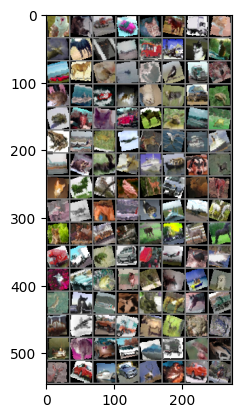

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

# The model
Let's start with the model we first saw

In [11]:
# importing the model from the model.py

import model
from model import NetBatchNormalization

model = NetBatchNormalization().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
       BatchNorm2d-2           [-1, 16, 30, 30]              32
              ReLU-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 16, 28, 28]           2,304
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 16, 30, 30]             256
       BatchNorm2d-8           [-1, 16, 30, 30]              32
              ReLU-9           [-1, 16, 30, 30]               0
        MaxPool2d-10           [-1, 16, 15, 15]               0
           Conv2d-11           [-1, 16, 13, 13]           2,304
      BatchNorm2d-12           [-1, 16, 13, 13]              32
             ReLU-13           [-1, 16, 13, 13]               0
           Conv2d-14           [-1, 16,

# Training and Testing

In [12]:
# Function fopr Training the model of the train dataset.
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Calculate loss
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

# Testing the trained model on test dataset to the check loss and model accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Let's Train and test our model

In [13]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  NetBatchNormalization().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)

    test(model, device, test_loader)



EPOCH: 1


Train: Loss=1.5222 Batch_id=390 Accuracy=34.47: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]



Test set: Average loss: 1.4376, Accuracy: 4731/10000 (47.31%)

EPOCH: 2


Train: Loss=1.2877 Batch_id=390 Accuracy=49.09: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 1.2424, Accuracy: 5544/10000 (55.44%)

EPOCH: 3


Train: Loss=1.1636 Batch_id=390 Accuracy=53.79: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 1.2927, Accuracy: 5577/10000 (55.77%)

EPOCH: 4


Train: Loss=1.4632 Batch_id=390 Accuracy=56.86: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 1.1378, Accuracy: 5896/10000 (58.96%)

EPOCH: 5


Train: Loss=1.0600 Batch_id=390 Accuracy=58.74: 100%|██████████| 391/391 [00:56<00:00,  6.95it/s]



Test set: Average loss: 1.0560, Accuracy: 6233/10000 (62.33%)

EPOCH: 6


Train: Loss=0.9654 Batch_id=390 Accuracy=60.10: 100%|██████████| 391/391 [00:47<00:00,  8.29it/s]



Test set: Average loss: 1.0545, Accuracy: 6308/10000 (63.08%)

EPOCH: 7


Train: Loss=1.2499 Batch_id=390 Accuracy=61.88: 100%|██████████| 391/391 [00:48<00:00,  8.12it/s]



Test set: Average loss: 0.9747, Accuracy: 6604/10000 (66.04%)

EPOCH: 8


Train: Loss=1.1245 Batch_id=390 Accuracy=62.47: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]



Test set: Average loss: 0.9253, Accuracy: 6764/10000 (67.64%)

EPOCH: 9


Train: Loss=0.9666 Batch_id=390 Accuracy=63.27: 100%|██████████| 391/391 [00:46<00:00,  8.34it/s]



Test set: Average loss: 0.9144, Accuracy: 6758/10000 (67.58%)

EPOCH: 10


Train: Loss=1.2639 Batch_id=390 Accuracy=64.25: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]



Test set: Average loss: 0.8572, Accuracy: 6994/10000 (69.94%)

EPOCH: 11


Train: Loss=1.0160 Batch_id=390 Accuracy=64.69: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.8747, Accuracy: 6960/10000 (69.60%)

EPOCH: 12


Train: Loss=1.0072 Batch_id=390 Accuracy=65.22: 100%|██████████| 391/391 [00:47<00:00,  8.16it/s]



Test set: Average loss: 0.8920, Accuracy: 6881/10000 (68.81%)

EPOCH: 13


Train: Loss=1.1371 Batch_id=390 Accuracy=65.63: 100%|██████████| 391/391 [00:47<00:00,  8.18it/s]



Test set: Average loss: 0.8070, Accuracy: 7155/10000 (71.55%)

EPOCH: 14


Train: Loss=1.1201 Batch_id=390 Accuracy=66.00: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 0.8671, Accuracy: 6992/10000 (69.92%)

EPOCH: 15


Train: Loss=0.9020 Batch_id=390 Accuracy=66.68: 100%|██████████| 391/391 [00:47<00:00,  8.22it/s]



Test set: Average loss: 0.7941, Accuracy: 7236/10000 (72.36%)

EPOCH: 16


Train: Loss=0.9652 Batch_id=390 Accuracy=67.23: 100%|██████████| 391/391 [00:47<00:00,  8.17it/s]



Test set: Average loss: 0.7843, Accuracy: 7320/10000 (73.20%)

EPOCH: 17


Train: Loss=0.9560 Batch_id=390 Accuracy=67.41: 100%|██████████| 391/391 [00:47<00:00,  8.25it/s]



Test set: Average loss: 0.8038, Accuracy: 7151/10000 (71.51%)

EPOCH: 18


Train: Loss=1.0582 Batch_id=390 Accuracy=67.68: 100%|██████████| 391/391 [00:47<00:00,  8.26it/s]



Test set: Average loss: 0.7878, Accuracy: 7255/10000 (72.55%)

EPOCH: 19


Train: Loss=1.1324 Batch_id=390 Accuracy=67.88: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]



Test set: Average loss: 0.8024, Accuracy: 7218/10000 (72.18%)

EPOCH: 20


Train: Loss=0.8201 Batch_id=390 Accuracy=68.34: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]



Test set: Average loss: 0.7781, Accuracy: 7276/10000 (72.76%)



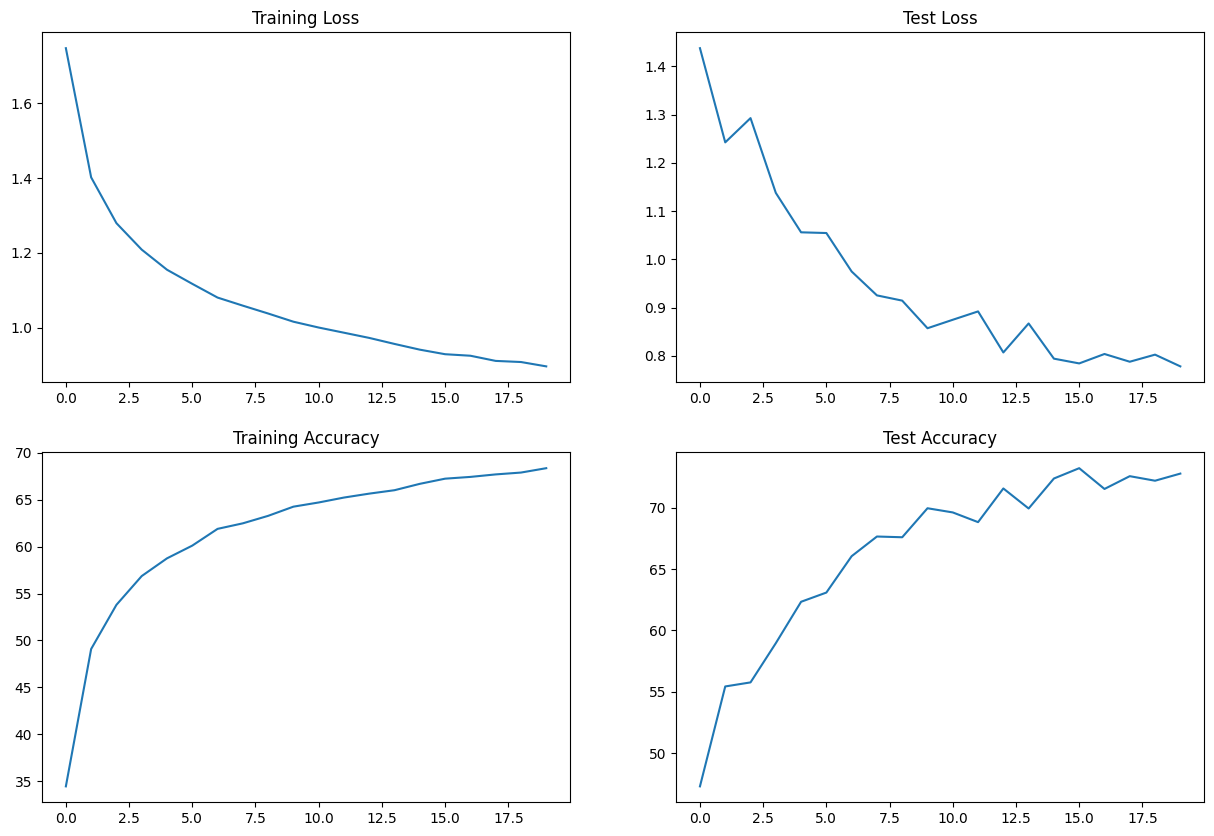

In [14]:
#!pip install utils
# Display the loss and accuracy in tranining and Test Data.
import utils
from utils import display_plot

display_plot(train_losses,train_acc,test_losses,test_acc)


GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat


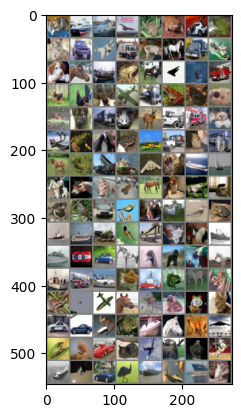

In [15]:
# Check the Test Data Set

dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [16]:
# Check the Prediction as classes that performed well, and the classes that did not perform well:


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model = NetBatchNormalization().to(device)
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == target).squeeze()
        for i in range(4):
            label = target[i].to(device)
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

cuda
Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse : 12 %
Accuracy of  ship : 81 %
Accuracy of truck :  0 %


In [17]:
from utils import convert_to_imshow_format

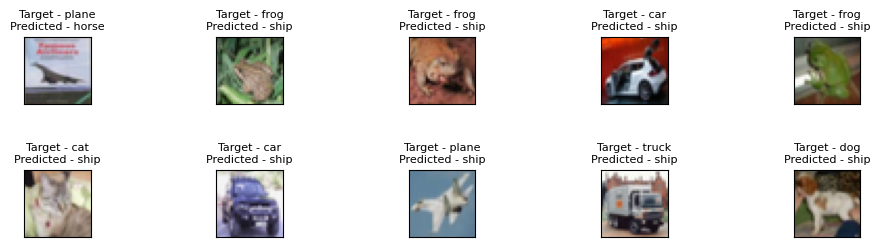

In [30]:
# Shows the images in first batch of the test_loader 128 images, in 1*128 format with label
dataiter = iter(test_loader)
images, labels = next(dataiter)

#print(len(images))


#model = Net().to(device)
model = NetBatchNormalization()
model.eval()

incorrect_pred = []

for idx,p in enumerate(predicted):
  #print("index --- ",idx)
  #print("predicted ---",classes[p])
  #print("Target ---",classes[labels[idx]])
  #print("Compare", classes[p] != classes[labels[idx]])
  if classes[p] != classes[labels[idx]]:

  #if p != labels[idx]:
    incorrect_pred.append(idx)
  #print(incorrect_pred)

index = 0
# show only the first 10 images in 2,5 format
fig, axes = plt.subplots(2, 5, figsize=(12,5))
plt.subplots_adjust(bottom=2.3, top=2.7, hspace=1)
#for idx, image in enumerate(images):
for p in range(0,2):
  for q in range(0,5):
    #print(idx)

    if index >= 10:
      break
    index=index+1
    #print(image.type)
    axes[p,q].imshow(convert_to_imshow_format(images[incorrect_pred[index]]))
    axes[p,q].set_title('Target - ' + classes[labels[incorrect_pred[index]]]+'\n'+'Predicted - '+ classes[predicted[incorrect_pred[index]]],fontsize = 8)
    axes[p,q].set_xticks([])
    axes[p,q].set_yticks([])


## Model 3

Results:

*   Parameters: Total params: 35,060
*   Train: (68.34)%
*   Test set: (73.20%)
*   EPOCH : 20


*   Analysis:
1. Model is underfitting.
2. The accuracy has reached the 73.20% with the Batch Normalization.
